# FinQA+RAPTOR Tree Construction Demo

## 기본 설정, 데이터 로드

In [9]:
import sys
import os
# raptor 디렉토리 경로 추가
sys.path.append(os.path.abspath('/Users/jisu/Desktop/Capstone_NaverCloud/FinBot-NCP/raptor'))

In [10]:
import json
import time
from typing import List, Dict, Union
from raptor.RetrievalAugmentation import RetrievalAugmentation  
from raptor.utils import HyperClovaExecutor, process_finqa_document
from raptor.custom_tokenizer import FinQATokenizer, SafeFinQATokenizer
from raptor.config import OPENAI_API_KEY, CLOVA_HOST, CLOVA_API_KEY, CLOVA_API_GATEWAY_KEY, EXTRACT_CONFIG
from raptor.ExtractModel import MetaDataExecutor  # ExtractModel 임포트
from raptor.EmbeddingModels import HyperCLOVAEmbeddingModel

In [3]:
# NOTE: An OpenAI API key must be set here for application initialization, even if not in use.
# If you're not utilizing OpenAI models, assign a placeholder string (e.g., "not_used").

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [4]:
# HyperClovaX API 키 설정
hyperclova = HyperClovaExecutor(
    api_key = CLOVA_API_KEY,
    api_key_primary = CLOVA_API_GATEWAY_KEY
)

In [5]:
# FinQA 데이터 로드
def load_finqa_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# FinQA 데이터셋 경로 지정 및 로드
# finqa_path = "/Users/jisu/Downloads/데이터/밀리의서재_fixed.json"
finqa_path = "/Users/jisu/Downloads/json데이터/escaped_20221114000599.json"

finqa_data = load_finqa_data(finqa_path)

In [6]:
# 데이터 형식 확인
print("Sample FinQA document structure")
sample_doc = finqa_data[0] # 첫 번째 문서 출력
print(json.dumps(sample_doc, indent=2))

Sample FinQA document structure
{
  "metadata": {
    "corp_name": "POSCO\ud640\ub529\uc2a4",
    "report_date": "2021.12",
    "rcept_no": "20221114000599",
    "sector": "\ucca0\uac15\uae08\uc18d"
  }
}


## 1. pre_text, table, post_text 개별 Chunking, 각 chunk마다 metadata 추출

### 1.1 아래와 같은 구성으로, 로드한 json파일에 metadata가 포함되어 있지 않을 때

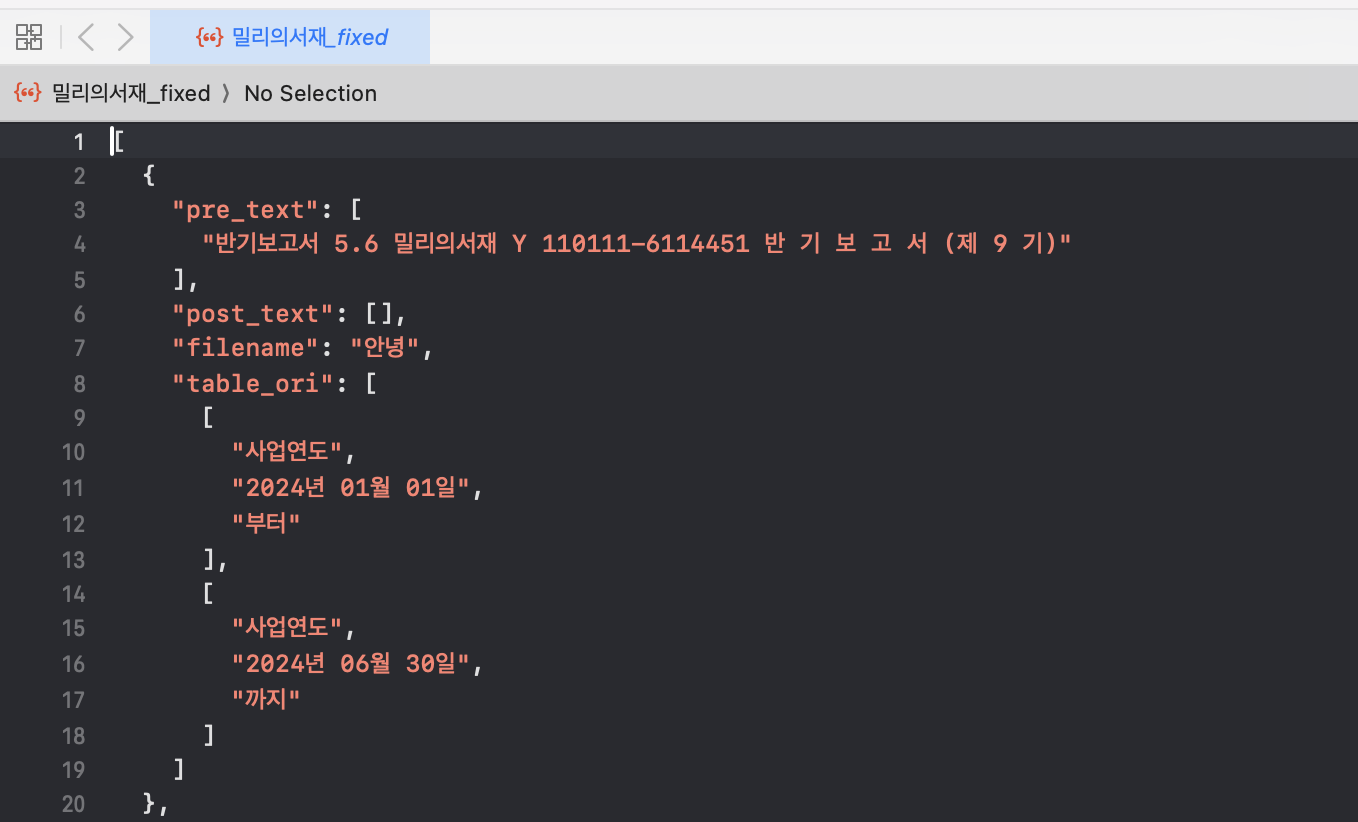

#### • 1, 2번 수행

In [21]:
# Chunking을 위한 토크나이저 초기화
tokenizer = SafeFinQATokenizer()
results = []

# ExtractModel의 MetadataExecutor 초기화 - 메타데이터 추출을 위한 모델
metadata_executor = MetaDataExecutor(
    host=CLOVA_HOST,
    api_key=CLOVA_API_KEY,
    api_key_primary_val=CLOVA_API_GATEWAY_KEY,
    request_id=EXTRACT_CONFIG['request_id']
)

print("\nProcessing FinQA documents...")
# 각 문서에 대해 처리 수행 (상위 10개)
for idx, doc in enumerate(finqa_data[:5]):
    print(f"\n{'='*50}")
    print(f"Document {idx+1}/5")
    print(f"ID: {doc.get('id')}")
    print(f"Filename: {doc.get('filename')}")
    
    # 문서별 결과를 저장할 딕셔너리 초기화
    document_results = {
        'id': doc.get('id'),
        'filename': doc.get('filename'),
        'chunks': []
    }
    
    try:
        #############################################
        # 1. Chunking 단계
        #############################################
        # FinQATokenizer를 사용하여 문서를 청크로 분할
        # - pre_text, table, post_text 각각을 별도의 청크로 생성
        # - 각 섹션은 하나의 청크로 통합됨
        encoded_doc = tokenizer.encode(doc)
        
        # 청크 수 출력
        print(f"\nChunk counts:")
        print(f"Pre-text chunks: {len(encoded_doc['pre_text_chunks'])}")
        print(f"Table chunks: {len(encoded_doc['table_chunks'])}")
        print(f"Post-text chunks: {len(encoded_doc['post_text_chunks'])}")
        print(f"Total chunks: {len(encoded_doc['all_chunks'])}")
        
        #############################################
        # 2. Metadata 추출 단계
        #############################################
        # 각 청크에 대해 메타데이터 추출 수행
        for chunk_idx, chunk in enumerate(encoded_doc['all_chunks']):
            print(f"\nProcessing chunk {chunk_idx + 1}/{len(encoded_doc['all_chunks'])}...")
            print(f"Chunk content: {chunk[:200]}...")  # 청크 내용 미리보기
            
            # 청크 타입 확인 (pre_text, table, post_text)
            chunk_type = "unknown"
            if chunk in encoded_doc['pre_text_chunks']:
                chunk_type = "pre_text"
            elif chunk in encoded_doc['table_chunks']:
                chunk_type = "table"
            elif chunk in encoded_doc['post_text_chunks']:
                chunk_type = "post_text"
            
            try:
                # ExtractModel을 사용하여 청크에서 메타데이터 추출
                # - 기업명, 산업분야 등의 정보 추출
                # - 각 정보에 대한 신뢰도와 근거 포함
                metadata = metadata_executor.extract_metadata(chunk)
                
                # 청크 결과 저장
                chunk_result = {
                    'chunk_idx': chunk_idx,
                    'chunk_type': chunk_type,
                    'chunk_text': chunk,
                    'metadata': metadata  # 추출된 메타데이터
                }
                
                document_results['chunks'].append(chunk_result)
                
                # 메타데이터 추출 결과 출력
                if metadata.get('success'):
                    print(f"Extracted metadata from chunk {chunk_idx + 1}:")
                    print(f"Company: {metadata['company_name'].get('name', 'Not found')}")
                    print(f"Industry: {metadata['industry'].get('sector', 'Not found')}")
                else:
                    print(f"Failed to extract metadata from chunk {chunk_idx + 1}")
                
            except Exception as e:
                print(f"Error processing chunk {chunk_idx + 1}: {str(e)}")
                continue
        
        # 문서의 모든 청크 처리가 완료되면 결과 저장
        results.append(document_results)
            
    except Exception as e:
        print(f"\nError processing document: {str(e)}")
        import traceback
        traceback.print_exc()
        
    # 다음 문서 처리 전 대기
    if idx < 4:
        print("\nWaiting 2 seconds before next document...")
        time.sleep(2)

# 결과를 JSON 파일로 저장
output_path = "metadata_results.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

2024-11-12 11:42:48,895 - Starting metadata extraction
2024-11-12 11:42:48,896 - Sending request to: https://clovastudio.apigw.ntruss.com/testapp/v1/chat-completions/HCX-003
2024-11-12 11:42:48,896 - Request data: {'messages': [{'role': 'system', 'content': '당신은 20년 경력의 재무분석 전문가입니다. 주어진 재무제표를 체계적으로 분석하여 다음 정보를 도출해주세요:\n\n1. 기업 식별\n- 재무제표의 계정과목 구성을 검토하여 기업명 파악\n- 특징적인 자산/부채 항목 기반 기업 추정\n- 매출 구조와 영업이익 패턴 분석\n\n2. 산업 분야 파악\n- 주요 매출원가 구성요소 분석\n- 영업용 자산의 특성 확인\n- 부채 및 자본 구조의 산업별 특징 대조\n- 수익성 지표와 업종별 평균 비교\n\n출력 형식:\n{\n  "기업명": {\n    "name": "분석된 기업명",\n    "confidence": "추정 신뢰도(상/중/하)",\n    "근거": "기업명 도출 근거"\n  },\n  "산업분야": {\n    "sector": "분석된 산업분야",\n    "confidence": "추정 신뢰도(상/중/하)",\n    "근거": "산업 도출 근거"\n  }\n}\n\n분석 시 주의사항:\n1. 모든 판단은 객관적 데이터에 근거할 것\n2. 추정의 불확실성은 명확히 표시할 것'}, {'role': 'user', 'content': '반기보고서 5.6 밀리의서재 Y 110111-6114451 반 기 보 고 서 (제 9 기)'}], 'topP': 0.6, 'topK': 0, 'maxTokens': 1000, 'temperature': 0.1, 'repeatPenalty': 2.0, 'stopBefore': [], 'includeAiFilters': 


Processing FinQA documents...

Document 1/5
ID: None
Filename: 안녕

Chunk counts:
Pre-text chunks: 1
Table chunks: 0
Post-text chunks: 0
Total chunks: 1

Processing chunk 1/1...
Chunk content: 반기보고서 5.6 밀리의서재 Y 110111-6114451 반 기 보 고 서 (제 9 기)...


2024-11-12 11:42:54,099 - Response status code: 200
2024-11-12 11:42:54,099 - Response headers: {'Server': 'nginx', 'Date': 'Tue, 12 Nov 2024 02:42:51 GMT', 'Content-Type': 'text/event-stream;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'vary': 'Origin,Access-Control-Request-Method,Access-Control-Request-Headers', 'set-cookie': 'CLOVASTUDIO-XSRF-TOKEN-NCP-PROD=bb4b53c7-b3b4-4af7-86d2-67ea69d8bf91; Path=/, JSESSIONID=F06AE741335687E4EC9AFB5C83F11E50; Path=/; HttpOnly', 'x-session-id': 'b38d4cb1-1445-49c9-be5e-90147332d698', 'x-request-id': 'a80529af477d44dba213960fd4b949ca', 'x-content-type-options': 'nosniff', 'x-xss-protection': '1; mode=block', 'cache-control': 'no-cache, no-store, max-age=0, must-revalidate', 'pragma': 'no-cache', 'expires': '0', 'x-frame-options': 'DENY', 'x-ratelimit-limit-requests': '200', 'x-ratelimit-remaining-requests': '199', 'x-ratelimit-reset-requests': '60s', 'x-ratelimit-limit-tokens': '30000', 'x-ratelimit-remaining-tokens'

Failed to extract metadata from chunk 1

Waiting 2 seconds before next document...

Document 2/5
ID: None
Filename: 안녕

Chunk counts:
Pre-text chunks: 0
Table chunks: 0
Post-text chunks: 0
Total chunks: 0

Waiting 2 seconds before next document...

Document 3/5
ID: None
Filename: 안녕

Chunk counts:
Pre-text chunks: 0
Table chunks: 0
Post-text chunks: 0
Total chunks: 0

Waiting 2 seconds before next document...

Document 4/5
ID: None
Filename: 안녕

Chunk counts:
Pre-text chunks: 0
Table chunks: 0
Post-text chunks: 0
Total chunks: 0

Waiting 2 seconds before next document...


2024-11-12 11:43:02,620 - Starting metadata extraction
2024-11-12 11:43:02,621 - Sending request to: https://clovastudio.apigw.ntruss.com/testapp/v1/chat-completions/HCX-003
2024-11-12 11:43:02,621 - Request data: {'messages': [{'role': 'system', 'content': '당신은 20년 경력의 재무분석 전문가입니다. 주어진 재무제표를 체계적으로 분석하여 다음 정보를 도출해주세요:\n\n1. 기업 식별\n- 재무제표의 계정과목 구성을 검토하여 기업명 파악\n- 특징적인 자산/부채 항목 기반 기업 추정\n- 매출 구조와 영업이익 패턴 분석\n\n2. 산업 분야 파악\n- 주요 매출원가 구성요소 분석\n- 영업용 자산의 특성 확인\n- 부채 및 자본 구조의 산업별 특징 대조\n- 수익성 지표와 업종별 평균 비교\n\n출력 형식:\n{\n  "기업명": {\n    "name": "분석된 기업명",\n    "confidence": "추정 신뢰도(상/중/하)",\n    "근거": "기업명 도출 근거"\n  },\n  "산업분야": {\n    "sector": "분석된 산업분야",\n    "confidence": "추정 신뢰도(상/중/하)",\n    "근거": "산업 도출 근거"\n  }\n}\n\n분석 시 주의사항:\n1. 모든 판단은 객관적 데이터에 근거할 것\n2. 추정의 불확실성은 명확히 표시할 것'}, {'role': 'user', 'content': '목     차 【 대표이사 등의 확인 】 대표이사의 확인서명_8.13.jpg 대표이사 등의 확인서명 I. 회사의 개요 1. 회사의 개요 (1) 연결대상 종속회사 현황(요약)당사는 본 보고서 작성기준일 현재, 연결 대상 종속회사가 없습니다. 가. 연결대상 종속 회사 개황'}], 'topP': 0.6, 'topK': 0,


Document 5/5
ID: None
Filename: 안녕

Chunk counts:
Pre-text chunks: 1
Table chunks: 0
Post-text chunks: 0
Total chunks: 1

Processing chunk 1/1...
Chunk content: 목     차 【 대표이사 등의 확인 】 대표이사의 확인서명_8.13.jpg 대표이사 등의 확인서명 I. 회사의 개요 1. 회사의 개요 (1) 연결대상 종속회사 현황(요약)당사는 본 보고서 작성기준일 현재, 연결 대상 종속회사가 없습니다. 가. 연결대상 종속 회사 개황...


2024-11-12 11:43:06,125 - Response status code: 200
2024-11-12 11:43:06,125 - Response headers: {'Server': 'nginx', 'Date': 'Tue, 12 Nov 2024 02:43:03 GMT', 'Content-Type': 'text/event-stream;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'vary': 'Origin,Access-Control-Request-Method,Access-Control-Request-Headers', 'set-cookie': 'CLOVASTUDIO-XSRF-TOKEN-NCP-PROD=d38dd382-4c7e-4bc0-af2c-089f9db86f11; Path=/, JSESSIONID=A0D6C0C71267AE65D7189FC25E8A565E; Path=/; HttpOnly', 'x-session-id': '1665b535-677f-4a95-88e1-c96dc90ae7aa', 'x-request-id': 'a80529af477d44dba213960fd4b949ca', 'x-content-type-options': 'nosniff', 'x-xss-protection': '1; mode=block', 'cache-control': 'no-cache, no-store, max-age=0, must-revalidate', 'pragma': 'no-cache', 'expires': '0', 'x-frame-options': 'DENY', 'x-ratelimit-limit-requests': '200', 'x-ratelimit-remaining-requests': '198', 'x-ratelimit-reset-requests': '46s', 'x-ratelimit-limit-tokens': '30000', 'x-ratelimit-remaining-tokens'

Failed to extract metadata from chunk 1


#### • 1, 2번에 대한 통계 결과 출력

In [22]:
# 최종 통계 출력
print("\n" + "="*50)
print("Final Statistics:")
print(f"Total documents processed: {len(results)}")

# 청크 단위 통계
total_chunks = sum(len(doc['chunks']) for doc in results)
successful_chunks = sum(1 for doc in results for chunk in doc['chunks'] 
                       if chunk['metadata'].get('success', False))

print(f"\nTotal chunks processed: {total_chunks}")
print(f"Successful chunks: {successful_chunks}")

# 메타데이터 통계
all_sectors = set()
all_companies = set()

for doc in results:
    for chunk in doc['chunks']:
        metadata = chunk['metadata']
        if metadata.get('success'):
            if 'industry' in metadata:
                sector = metadata['industry'].get('sector')
                if sector:
                    all_sectors.add(sector)
            if 'company_name' in metadata:
                company = metadata['company_name'].get('name')
                if company:
                    all_companies.add(company)

print(f"\nUnique sectors found: {len(all_sectors)}")
print("Sectors:", all_sectors)
print(f"\nUnique companies found: {len(all_companies)}")
print("Companies:", all_companies)

# 청크 타입별 메타데이터 추출 성공률
type_stats = {'pre_text': {'total': 0, 'success': 0},
              'table': {'total': 0, 'success': 0},
              'post_text': {'total': 0, 'success': 0}}

for doc in results:
    for chunk in doc['chunks']:
        chunk_type = chunk['chunk_type']
        if chunk_type in type_stats:
            type_stats[chunk_type]['total'] += 1
            if chunk['metadata'].get('success', False):
                type_stats[chunk_type]['success'] += 1

print("\nMetadata extraction success rate by chunk type:")
for chunk_type, stats in type_stats.items():
    if stats['total'] > 0:
        success_rate = (stats['success'] / stats['total']) * 100
        print(f"{chunk_type}: {success_rate:.2f}% ({stats['success']}/{stats['total']})")

print(f"\nDetailed results saved to {output_path}")


Final Statistics:
Total documents processed: 5

Total chunks processed: 2
Successful chunks: 0

Unique sectors found: 0
Sectors: set()

Unique companies found: 0
Companies: set()

Metadata extraction success rate by chunk type:
pre_text: 0.00% (0/2)

Detailed results saved to metadata_results.json


### 1.2 로드한 json파일에 metadata가 포함되어 있을 때

## 2. 하이퍼클로바X로 임베딩

In [23]:
# 모델 초기화
embedding_model = HyperCLOVAEmbeddingModel()

# 결과 불러오기
with open(output_path, 'r', encoding='utf-8') as f:
    results = json.load(f)

# 청크별 임베딩 계산
for doc in results:
    for chunk in doc['chunks']:
        text = chunk['chunk_text']
        # 임베딩 생성
        embedding = embedding_model.create_embedding(text)  # 메소드 이름을 수정함
        # 임베딩 결과 저장
        chunk['embedding'] = embedding  # NumPy 배열을 리스트로 변환

# 임베딩 결과를 새 JSON 파일에 저장
output_with_embeddings = "embedding_results.json"
with open(output_with_embeddings, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"Embeddings added and results saved to {output_with_embeddings}")


Embeddings added and results saved to embedding_results.json
